# CMPS242 HW3
## 1. Introduction

Spam detector is a tool which can distinguish spam emails and regular emails. With its help, useless emails can be automatically marked as spam, leave us a clean inbox.
The report would illustrate whole process how we implemented the spam detector.

## 2. Logistic Regression
Spam detector can be implemented with a statistical method named logistic regression. It usually used in the situation where has 2 cases as binary dependent variable—that is, where the output can take only two values, “0” and “1”, which represent outcome such as pass/fail, win/lose, alive/dead or healthy/sick. In this report, outcome(label) is spam or ham.
Logistic regression uses the sigmoid function $f(z)=\frac{1}{(1+e^{-2}}$, which can take any value from negative infinity to positive infinity as input, whereas the output is limit in interval (0, 1). The valuable z is defined as $z=\sum_{i=0}^{n}{w_i x_i}$, output f(z) is the target which we want it to be as close as 1/0.
The logistic regression algorithm is implemented as:

(1)Initialize all weights(wi)

(2)Calculate logistic cost function
$$L = -y\log(\sum(XW))-(1-y)\log(1-\sum(XW)) + \lambda||W||^2$$  

(3)Calculate gradient
$$diag(\sum(WX) - y)X + \lambda |W|$$

(4)Update the weights by minimizing loss function
$$w = w - \eta \times gradient$$

## 3. Batch gradient descent logistic regression
### 3.1 Introduction
Gradient Descent is one of the standard methods used for minimization of any convex function.when the gradient of the function is equal to zero by taking steps proportional to the negative of the gradient of the function,the optimal solution is found.For each gradient step, the gradient of the loss vector for all the examples in the batch is found and the weights for each feature is updated. And we would set some threshold precision value, until wt+1wt+1 is very close to wtwt. For detailed information of logistic regression and batch gradient.

### 3.2 Implementation
We implemented batch gradient descent logistic regression in Python using Jupyter Notebooks. The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text.
The following is our source code and result:



In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_activity = 'all'
import pandas as pd
train = pd.read_csv('https://classes.soe.ucsc.edu/cmps242/Spring18/hw/hw3/train.csv',encoding='Latin-1')
test = pd.read_csv('https://classes.soe.ucsc.edu/cmps242/Spring18/hw/hw3/test.csv',encoding='Latin-1')

### Preprocess Training Set 

In [3]:
# tokenization
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english'))
filter_sms = [sms for sms in train.sms.values]
word_token = [word_tokenize(sms) for sms in filter_sms]
filter_words = []
for word in word_token:
    filter_words.append([w for w in word if not w in stop_words])
filter_sms = []
for word in filter_words:
    filter_sms.append(' '.join(word))
vectorizer = CountVectorizer()
train_token = vectorizer.fit_transform(filter_sms)

# tfidf transform

transformer = TfidfTransformer(smooth_idf = True)
tfidf_train_token = transformer.fit_transform(train_token)
tfidf_train_token = tfidf_train_token.toarray()
colname = vectorizer.get_feature_names()
df_token = pd.DataFrame(data=tfidf_train_token,columns=colname)

In [4]:
# Standardizer
from sklearn import preprocessing
standardScaler = preprocessing.StandardScaler(with_mean=False)
standard_df_token = standardScaler.fit_transform(df_token)

In [5]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=1500)
df_token_pca=pca.fit_transform(standard_df_token)

In [6]:
# add bias term
import numpy as np
train_x = np.hstack((np.ones((3000,1)),df_token_pca))

In [ ]:
# likelihood function/logitic loss
def l_loss(y_,y):
    if y==1:
        loss = -np.log(y_)
    elif y==0:
        loss = -np.log(1-y_)
    return loss
l_loss = np.vectorize(l_loss)

def logitloss(y_,y):
    loss = l_loss(y_,y)
    where_inf = np.isinf(loss)
    loss[where_inf] = 150
    return loss

def sigmoid(w,x):
    return np.divide(np.exp(np.dot(x,w)),(np.add(1,np.exp(np.dot(x,w)))))

def gradient(y,x,w,lmd):
    #loss = logitloss(sigmoid(w,x),y).reshape(y.shape[0],)
    reg = lmd*w
    reg[0] = 0 # not regularize the bias term
    return np.add(reg,np.dot(np.diag(np.subtract(sigmoid(w,x).reshape(y.shape[0],),y)),x)).mean(axis=0).reshape((1501,1))
    

def gradientDescent(y,w,x,eta,lmd):
    # eta: learning rate
    # lmb: regularization term
    for i in range(1000):
        lossPre = logitloss(sigmoid(w,x),y).sum()
        w = np.subtract(w,np.multiply(eta,gradient(y,x,w,lmd)))
        lossPost = logitloss(sigmoid(w,x),y).sum()
        if (lossPre-lossPost)/lossPre<0.05:
            break
    return w
        

# vectorize functions
logitloss = np.vectorize(logitloss)

# preprocess the data
np.random.seed(0) # set the seed to 0
w_init = np.random.rand(1501,1)
train_y=pd.get_dummies(train.label.values)['spam'].values
train_y=train_y.astype('float').reshape(len(train_y),1)

# concatenate x and y
trainset = np.hstack((train_x,train_y))

#w_opt = gradientDescent(train_y, w_init, train_x, 0.01, 0.1)
#w_opt.shape



#### Cross Validation

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
lambda_candi = [0.01,0.1,0.3,0.5,0.7,1,5,7,10,30,50,70,100]
error_sum = []
i = 1
for lmd in lambda_candi:
    error = []
    for train_index, test_index in kf.split(train_x):
        w_init = np.ones((1501,1))
        X_train, y_train = train_x[train_index], train_y[train_index]
        X_test, y_test = train_x[test_index], train_y[test_index]
        w_opt = gradientDescent(y_train,w_init,X_train,0.01,lmd)
        loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
        error.append(loss)
    error = np.array(error).reshape(10,1)
    if i==1:
        error_sum = error
    else:
        error_sum = np.hstack((error_sum,error))
    #print('1 lambda done')
    print(error_sum)
    i += 1
#print('All lambda done!')    

/Users/xianglongtan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


[[23.96477174]
 [16.12581631]
 [18.44573538]
 [18.88062286]
 [15.87104011]
 [20.99322804]
 [16.90591346]
 [19.28793085]
 [21.29481503]
 [15.91171882]]
[[23.96477174 23.91478552]
 [16.12581631 16.07433626]
 [18.44573538 18.39028244]
 [18.88062286 18.85218407]
 [15.87104011 15.816086  ]
 [20.99322804 20.97594341]
 [16.90591346 16.85473348]
 [19.28793085 19.2302814 ]
 [21.29481503 20.87253894]
 [15.91171882 15.89106985]]
[[23.96477174 23.91478552 22.67795829]
 [16.12581631 16.07433626 15.96641653]
 [18.44573538 18.39028244 17.90254168]
 [18.88062286 18.85218407 18.41312767]
 [15.87104011 15.816086   15.70280538]
 [20.99322804 20.97594341 20.93853897]
 [16.90591346 16.85473348 16.74946557]
 [19.28793085 19.2302814  19.12159461]
 [21.29481503 20.87253894 20.78902526]
 [15.91171882 15.89106985 15.46894179]]
[[23.96477174 23.91478552 22.67795829 22.57949739]
 [16.12581631 16.07433626 15.96641653 15.87226954]
 [18.44573538 18.39028244 17.90254168 17.79647734]
 [18.88062286 18.85218407 18.41312

In [ ]:
error_cv = pd.DataFrame(data=error_sum,columns = lambda_candi)
cv_sta = error_cv.describe()
mean = cv_sta.loc['mean']
std = cv_sta.loc['std']
print('mean:\n',mean)
print('standart deviation:\n',std)
cv_sta

In [ ]:
%matplotlib inline
plt.plot(lambda_candi,std)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("$variance$")

In [ ]:
w_init = np.ones((1501,1))
X_train, y_train = train_x[train_index], train_y[train_index]
X_test, y_test = train_x[test_index], train_y[test_index]
w_opt = gradientDescent(y_train,w_init,X_train,0.01,7)
loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
print(loss)

In [ ]:
#Process Testset
test_x = test.sms.values
test_y = test.label.values
test_token = vectorizer.transform(test_x)
test_token_idf = transformer.transform(test_token)
df_test_token = pd.DataFrame(data=test_token_idf.toarray(),columns=colname)
standard_df_test_token = standardScaler.transform(df_test_token)
df_test_token_pca=pca.transform(standard_df_test_token)
test_x = np.hstack((np.ones((test_y.shape[0],1)),df_test_token_pca))
test_y = pd.get_dummies(test_y)['spam'].values

### 3.3 Result of Batch Gradient Descent Logistic Regression
The batch gradient descent algorithm was implemented. The training and test losses were found using the 10 fold cross validation. we initiate 2 kinds of Weight, first is ramdom, second is all 1.

1. Random:
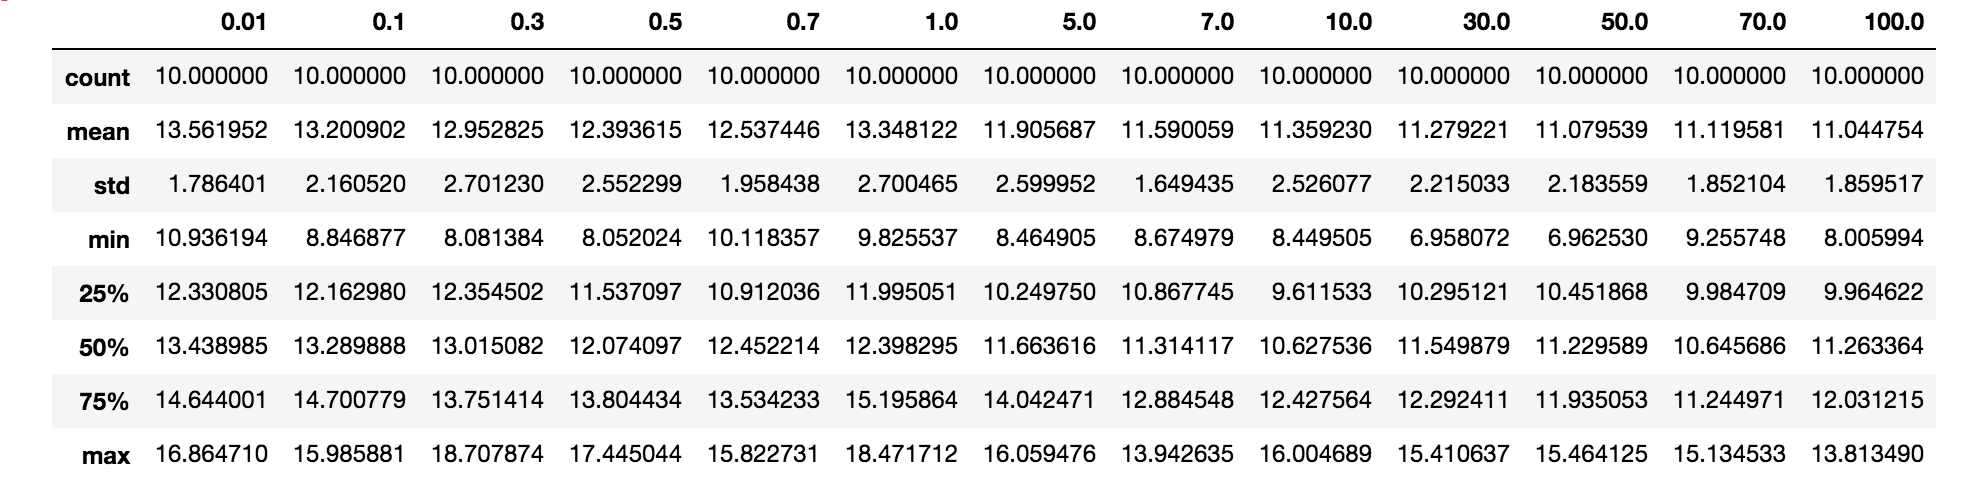

### Error bar
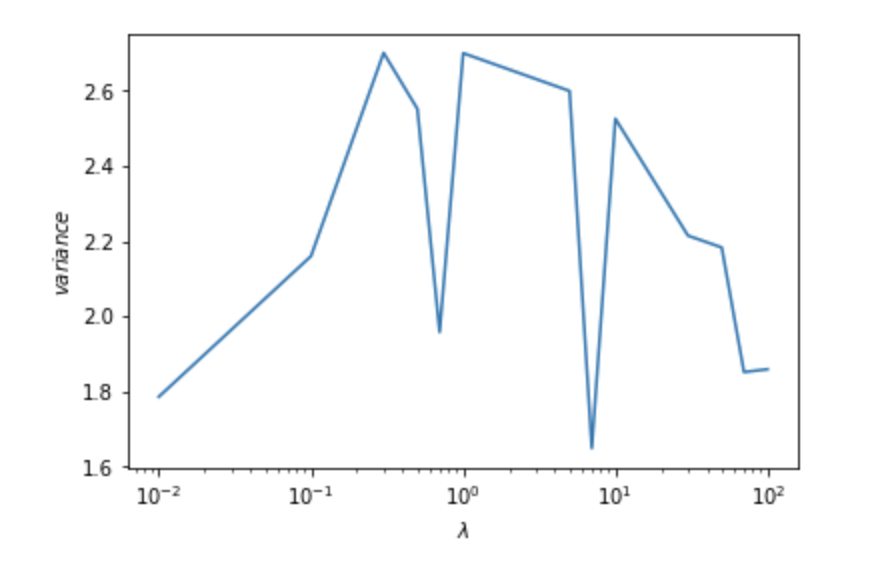

2. all 1
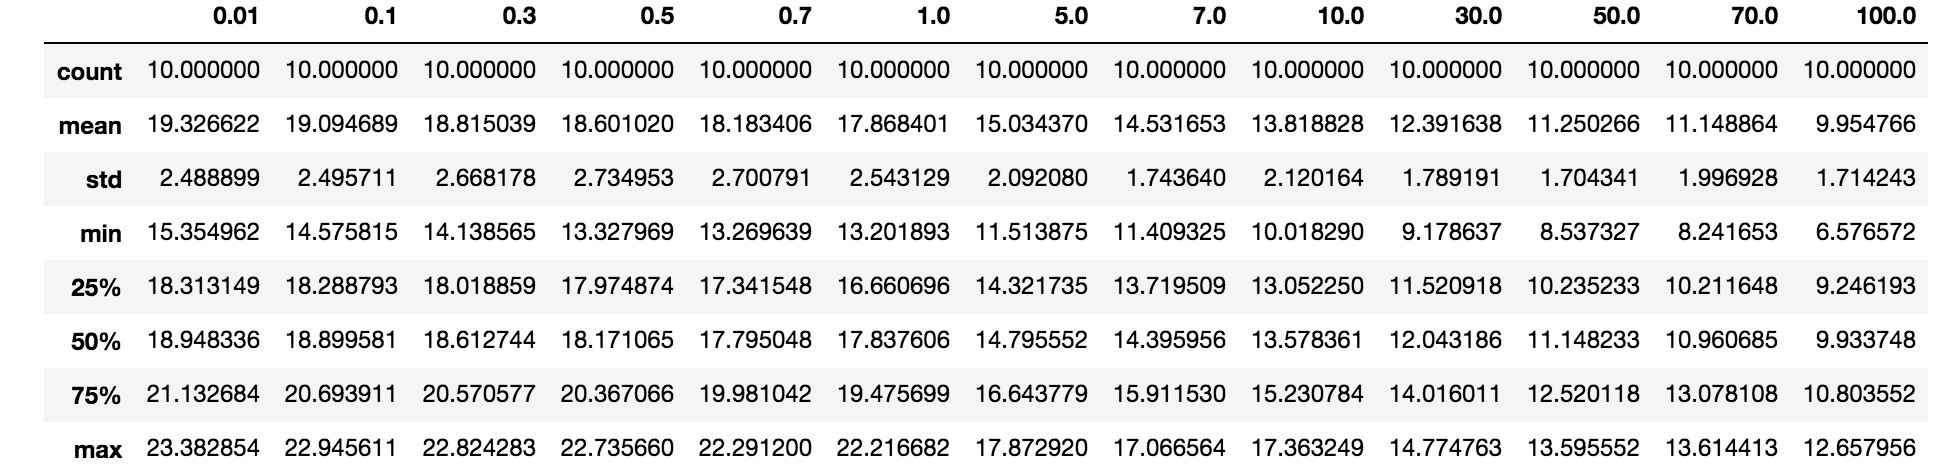

### Error bar
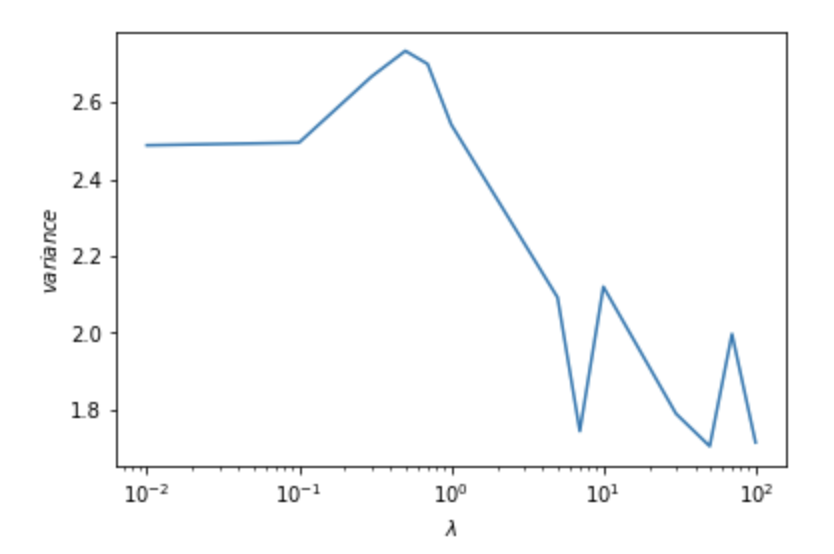

With 2 kinds of initial weight, from the traning above, precision set=0.05, η=0.01, we can find the best λ both are 7. The logistic loss of the best lambda on minimum with all 1 initial weight is 11.40932535.

# 4. Extra
## 4.1 Add bias term
We already expanded the matrix of the sample data by adding one more colomn representing the bias with the code below.

In [ ]:
# add bias term
import numpy as np
train_x = np.hstack((np.ones((3000,1)),df_token_pca))

##  4.2 Different Regularizion Term $\lambda ||w||$
### 4.2.1 Implementation
To prevent overfitting, we add regularized fator. We set regularization by using the  λ||w||  instead of  λ||w||2 , while ||w|| is the sum of absolute value of w(weight). We set initial w all 1.

In [105]:
def gradient_L1reg(y,x,w,lmd):
    #loss = logitloss(sigmoid(w,x),y).reshape(y.shape[0],)
    reg = lmd*np.ones((1501,1))
    reg[0] = 0 # not regularize the bias term
    return np.add(reg,np.dot(np.diag(np.subtract(sigmoid(w,x).reshape(y.shape[0],),y)),x)).mean(axis=0).reshape((1501,1))

def gradientDescent_L1reg(y,w,x,eta,lmd):
    for i in range(1000):
        lossPre = logitloss(sigmoid(w,x),y).sum()
        w = np.subtract(w,np.multiply(eta,gradient_L1reg(y,x,w,lmd)))
        lossPost = logitloss(sigmoid(w,x),y).sum()
        if (lossPre-lossPost)/lossPre<0.05:
            #print('optimal loss: ',lossPost)
            break
    return w
#w_init=np.ones((1501,1))
#w_opt_l1 = gradientDescent_L1reg(train_y, w_init, train_x, 0.01, 0.1)

from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
lambda_candi = [0.01,0.1,0.3,0.5,0.7,1,5,7,10,30,50,70,100]
error_sum = []
i = 1
for lmd in lambda_candi:
    error = []
    for train_index, test_index in kf.split(train_x):
        w_init = np.ones((1501,1))
        X_train, y_train = train_x[train_index], train_y[train_index]
        X_test, y_test = train_x[test_index], train_y[test_index]
        w_opt = gradientDescent_L1reg(y_train,w_init,X_train,0.01,lmd)
        loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
        error.append(loss)
    error = np.array(error).reshape(10,1)
    if i==1:
        error_sum = error
    else:
        error_sum = np.hstack((error_sum,error))
    print('1 lambda done')
    print(error_sum)
    i += 1
print('All lambda done!') 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


1 lambda done
[[22.99647683]
 [16.1453175 ]
 [19.12422103]
 [21.56830085]
 [18.48981826]
 [18.24843937]
 [18.75781607]
 [20.79882136]
 [20.96131712]
 [14.97440813]]
1 lambda done
[[22.99647683 22.85462689]
 [16.1453175  15.74220229]
 [19.12422103 18.6198365 ]
 [21.56830085 21.46076319]
 [18.48981826 17.95162111]
 [18.24843937 18.2171822 ]
 [18.75781607 18.64010828]
 [20.79882136 20.63406554]
 [20.96131712 20.4396072 ]
 [14.97440813 14.150253  ]]
1 lambda done
[[22.99647683 22.85462689 22.25737087]
 [16.1453175  15.74220229 15.68224994]
 [19.12422103 18.6198365  17.61175885]
 [21.56830085 21.46076319 19.75955895]
 [18.48981826 17.95162111 17.878112  ]
 [18.24843937 18.2171822  17.46200143]
 [18.75781607 18.64010828 16.91400224]
 [20.79882136 20.63406554 19.57292152]
 [20.96131712 20.4396072  19.81299275]
 [14.97440813 14.150253   13.24052176]]
1 lambda done
[[22.99647683 22.85462689 22.25737087 21.74130278]
 [16.1453175  15.74220229 15.68224994 13.76068878]
 [19.12422103 18.6198365  17.

1 lambda done
[[22.99647683 22.85462689 22.25737087 21.74130278 20.08315107 18.67915074
  15.98944622 15.0501258  14.06582852  7.02969076  4.05914662  8.61140498]
 [16.1453175  15.74220229 15.68224994 13.76068878 13.18565619 12.47594734
  12.07247533 10.98913023 10.59555748  6.28149122  4.62475497 12.55271965]
 [19.12422103 18.6198365  17.61175885 17.00771842 16.01807308 14.54586159
  13.33707924  9.11662833  9.31128578  4.38416097  3.5181689  10.37289794]
 [21.56830085 21.46076319 19.75955895 19.15687276 18.58871154 17.56220059
  14.3701395  12.57151444 10.73696238  6.1455323   5.05176842 12.95605225]
 [18.48981826 17.95162111 17.878112   17.03989914 16.46378218 15.42091401
  12.34881432 10.558865   11.00295907  5.23248726  4.63768124 11.2825836 ]
 [18.24843937 18.2171822  17.46200143 16.85988739 18.03596466 17.56224015
  13.4110614  13.41609064 10.34042891  5.63995558  4.77975933 11.11307058]
 [18.75781607 18.64010828 16.91400224 15.93840447 15.36945433 16.85695709
  11.25243665 10.6

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


1 lambda done
[[22.99647683 22.85462689 22.25737087 21.74130278 20.08315107 18.67915074
  15.98944622 15.0501258  14.06582852  7.02969076  4.05914662  8.61140498
          nan]
 [16.1453175  15.74220229 15.68224994 13.76068878 13.18565619 12.47594734
  12.07247533 10.98913023 10.59555748  6.28149122  4.62475497 12.55271965
          nan]
 [19.12422103 18.6198365  17.61175885 17.00771842 16.01807308 14.54586159
  13.33707924  9.11662833  9.31128578  4.38416097  3.5181689  10.37289794
          nan]
 [21.56830085 21.46076319 19.75955895 19.15687276 18.58871154 17.56220059
  14.3701395  12.57151444 10.73696238  6.1455323   5.05176842 12.95605225
  28.4772486 ]
 [18.48981826 17.95162111 17.878112   17.03989914 16.46378218 15.42091401
  12.34881432 10.558865   11.00295907  5.23248726  4.63768124 11.2825836
          nan]
 [18.24843937 18.2171822  17.46200143 16.85988739 18.03596466 17.56224015
  13.4110614  13.41609064 10.34042891  5.63995558  4.77975933 11.11307058
          nan]
 [18.7578

In [106]:
error_cv = pd.DataFrame(data=error_sum,columns = lambda_candi)
cv_sta = error_cv.describe()
mean = cv_sta.loc['mean']
std = cv_sta.loc['std']
print('mean:\n',mean)
print('standart deviation:\n',std)
cv_sta

mean:
 0.01      19.206494
0.10      18.871027
0.30      18.019149
0.50      17.203096
0.70      16.658698
1.00      15.845659
5.00      12.872326
7.00      11.768746
10.00     10.756591
30.00      5.346428
50.00      4.281631
70.00     12.224331
100.00    28.010223
Name: mean, dtype: float64
standart deviation:
 0.01      2.460306
0.10      2.616381
0.30      2.508599
0.50      2.668186
0.70      2.448310
1.00      2.193838
5.00      1.970201
7.00      2.043147
10.00     1.775672
30.00     1.080329
50.00     0.800279
70.00     2.123118
100.00    0.660474
Name: std, dtype: float64


,0.01,0.1,0.3,0.5,0.7,1.0,5.0,7.0,10.0,30.0,50.0,70.0,100.0
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000
mean,19.206494,18.871027,18.019149,17.203096,16.658698,15.845659,12.872326,11.768746,10.756591,5.346428,4.281631,12.224331,28.010223
std,2.460306,2.616381,2.508599,2.668186,2.448310,2.193838,1.970201,2.043147,1.775672,1.080329,0.800279,2.123118,0.660474
min,14.974408,14.150253,13.240522,12.728461,12.625035,12.475947,9.185140,9.116628,8.534086,3.811661,3.292269,8.611405,27.543197
25%,18.308784,18.018011,17.051002,16.168775,15.531609,14.690496,11.887095,10.572505,9.555889,4.489168,3.598963,11.155449,27.776710
50%,18.941019,18.629972,17.744935,17.023809,16.792211,16.138936,12.842947,11.403178,10.467993,5.436221,4.341951,12.125861,28.010223
75%,20.920693,20.585451,19.712900,19.003174,18.450525,17.562230,14.130370,13.204947,10.936460,6.146138,4.744240,12.954070,28.243736
max,22.996477,22.854627,22.257371,21.741303,20.083151,18.679151,15.989446,15.050126,14.065829,7.029691,5.683162,16.038013,28.477249


### Error bar

Text(0,0.5,'$mean$')

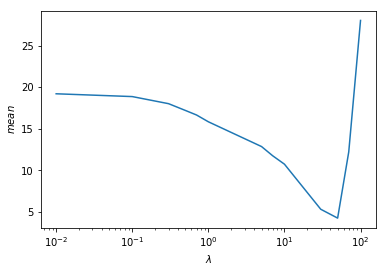

In [107]:
plt.plot(lambda_candi,mean)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("$mean$")

Text(0,0.5,'$variance$')

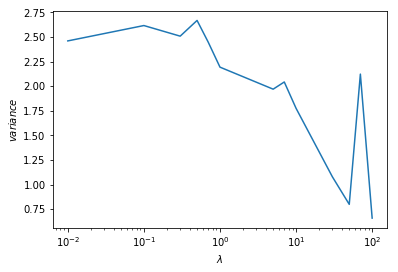

In [108]:
plt.plot(lambda_candi,std)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("$variance$")

In [113]:
w_init = np.ones((1501,1))
X_train, y_train = train_x[train_index], train_y[train_index]
X_test, y_test = train_x[test_index], train_y[test_index]
w_opt = gradientDescent(y_train,w_init,X_train,0.01,50)
loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
print(loss)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


[8.53732697]


### 4.2.2 Result Analyze
From the training above, we have the best lambda is 50, because it has smallest mean loss and small variance loss, with lambda=50, we can calculate loss=8.53732697.

## 4.3 squared loss

In [192]:
def squareloss(theta,x,y):
    pre=sigmoid(theta,x).astype(float)
    y=y.reshape(y.size,1)
    J=pre-y
    J=J.reshape(J.size)
    J=np.square(J)
    J=np.mean(J)
    return J


In [193]:
def sqrgrad(theta,xtrain,ytrain):
    pre=sigmoid(theta,xtrain).astype(float)
    t=pre-ytrain
    t=t*pre/(1+np.exp(xtrain.dot(theta).astype(float)))
    t=t.reshape(t.size)
    t=np.diag(t)
    grad=np.mean(xtrain.T.dot(t),axis=1)
    grad=grad.reshape(grad.size,1)
    grad=grad+lbd*theta
    return grad

In [194]:
def sqrmodeltrain(xtr,ytr,lbd):
    i=0
    alpha=0.2
    delta=1e6
    n=xtr.shape[1]
    theta=np.random.rand(n,1)
    ltr=squareloss(theta,xtr,ytr)
    while (delta>0.01*ltr) and (i<1000):
        theta=theta-alpha*sqrgrad(theta,xtr,ytr)
        p=squareloss(theta,xtr,ytr)
        delta=ltr-p
        ltr=p
        i=i+1
    return theta

### Cross Validation

In [196]:
lam=[]
for i in range(0,10):
    l=np.random.uniform(10**(i-5),10**(i-4))
    lam.append(l)

L=[]
var=[]
for k in range(0,len(lam)):
    error = []
    for train_index, test_index in kf.split(train_x):
        X_train, y_train = train_x[train_index], train_y[train_index]
        X_test, y_test = train_x[test_index], train_y[test_index]
        theta=sqrmodeltrain(X_train,y_train,lam[k])
        l=squareloss(theta,X_test,y_test)
        error.append(l)
    var.append(np.var(error))
    J=np.mean(error)
    L.append(J)
n=np.argmin(L)
w=sqrmodeltrain(train_x,train_y,lam[n])
print("Optimistic lambda is",lam[n])
print("Loss on trainset:",squareloss(w,train_x,train_y))
print("Loss on testset:",squareloss(w,test_x,test_y))

Optimistic lambda is 0.8524246577914804
Loss on trainset: 0.41297392005955996
Loss on testset: 0.5026164817352772


### Error bar

Text(0.5,1,'Error Bar')

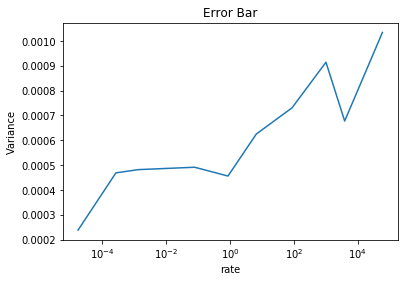

In [197]:
plt.plot(lam,var)
plt.xscale('log')
plt.xlabel("rate")
plt.ylabel("Variance")
plt.title("Error Bar")

## 4.4 EG±
### 4.4.1 Introduction of EG+-
A logistic regression with EG+- stopsign is the difference between  wt  and  wt+1 , which we call exponentiated gradient algorithm with positive and negative weights. The formula is given ad follows:


$$w_{t+1}^{+}=w_{t}^{+}+exp{−\eta(\sum_{i=1}^{N}{(y_n-t_n)x_n}+\lambda w_{t}^{+}}$$

$$w_{t+1}^{-}=w_{t}^{-}+exp{−\eta(\sum_{i=1}^{N}{(y_n-t_n)x_n}+\lambda w_{t}^{-}}$$

$$y_n=(w_{t}^{+}−w_{t}^{-})x_n$$

### 4.4.2 Implementation

In [14]:
def expmodeltrain(xtrain,ytrain,alpha):
    n=xtrain.shape[1]
    m=len(ytrain)
    wt=np.random.rand(n,1)/n
    wtp=wt
    wtn=1/n-wtp;
    alpha=0.2
    for t in range(0,1):
        w=wtp-wtn
        
        pre=xtrain[t,:].dot(w)
        lgd=-ytrain[t]/(1+np.exp(pre))+(1-ytrain[t])*np.exp(pre)/(1+np.exp(pre))
        rp=np.exp(-alpha*lgd*xtrain[t,:]);
        rp=rp.reshape(rp.size,1)
        rn=np.exp(alpha*lgd*xtrain[t,:]);
        rn=rn.reshape(rn.size,1)
        wtp=wtp*rp/sum(sum(wtp*rp+wtn*rn))
        wtn=wtn*rn/sum(sum(wtp*rp+wtn*rn))
    
    return wtp-wtn

### Cross Validation

In [16]:
rate=np.linspace(1e-2,1,10)
L=[]
var=[]
for alpha in rate:
    error = []
    for train_index, test_index in kf.split(train_x):
        X_train, y_train = train_x[train_index], train_y[train_index]
        X_test, y_test = train_x[test_index], train_y[test_index]
        weight=expmodeltrain(X_train,y_train,alpha)
        l=logitloss(sigmoid(weight,X_test),y_test).mean(axis=0)
        error.append(l)
    var.append(np.var(error))
    J=np.mean(error)
    L.append(J)
n=np.argmin(L)
w=expmodeltrain(train_x,train_y,rate[n])
print("Optimistic update rate is",rate[n])
print("Loss on trainset:",logitloss(sigmoid(w,train_x),train_y).mean(axis=0))
print("Loss on testset:",logitloss(sigmoid(w,test_x),test_y.reshape(test_y.size,1)).mean(axis=0))

Optimistic update rate is 0.23
Loss on trainset: [0.69281491]
Loss on testset: [0.69211634]


### Error Bar 

Text(0.5,1,'Error Bar')

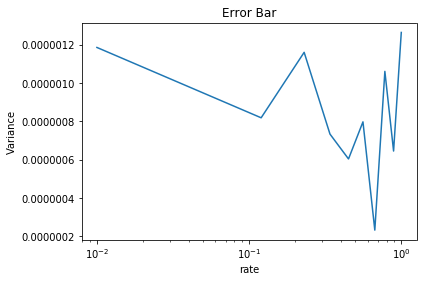

In [17]:
plt.plot(rate,var)
plt.xscale('log')
plt.xlabel("rate")
plt.ylabel("Variance")
plt.title("Error Bar")

## 4.5 Weighted Linear Least Square  
We may face the problem of heteroskedasticity in regression, so we implement weighted least square.  

The mathematical form of weighted linear least square is minimizing $\sum_{i=1}^nw_i(y_i-x_i\beta)^2$.   

In matrix:
$$min\  (Y-X\beta)^TW(Y-X\beta)$$  

Here, we assume the weight matrix is $W^{-1}$, $W$ is diagonal matrix of error.  

Hence, beta would be:
$$\beta^* = (X^TWX)X^TWY$$

Add a L2 regularization term:
$$min\  (Y-X\beta)^TW(Y-X\beta) + \frac{\lambda}{2} ||\beta||^2$$  
$$\beta^* = (X^TWX+\lambda I)X^TWY$$

In [ ]:
import time

def WLS(X,y):
    b_ols = (np.dot(X.T,X).T).dot(np.dot(X.T,y))
    error = np.square(y - np.dot(X,b_ols))
    weight = np.diag(np.divide(1,error).reshape(error.shape[0]))
    b_wls = np.linalg.inv(np.dot(X.T,np.dot(weight,X))).dot(np.dot(X.T,np.dot(weight,y)))
    return b_wls
start = time.time()
b_wls = WLS(train_x,train_y)
end = time.time()
print(end-start)

def WLS_L2reg(X,y,lmd):
    b_ols = (np.dot(X.T,X).T).dot(np.dot(X.T,y))
    error = np.square(y - np.dot(X,b_ols))
    weight = np.diag(np.divide(1,error).reshape(error.shape[0]))
    b_wls = np.linalg.inv(np.add(np.dot(X.T,np.dot(weight,X)),lmd*np.ones((X.shape[1],X.shape[1])))).dot(np.dot(X.T,np.dot(weight,y)))
    return b_wls

start = time.time()
b_wls = WLS_L2reg(train_x,train_y,0.1)
end = time.time()
print(end-start)

0.5718998908996582
0.6520960330963135


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


## 4.6 Stochastic Gradient descent with L2 regularization
### 4.6.1 Implementation

In [124]:
def gradient_SGD(y,x,w,lmd):
    #loss = logitloss(sigmoid(w,x),y).reshape(y.shape[0],)
    reg = lmd*w
    reg[0] = 0 # not regularize the bias term
    gradient = ((sigmoid_SGD(w,x)-y)*x).reshape((((sigmoid_SGD(w,x)-y)*x).shape[0],1))+reg
    return gradient

def sigmoid_SGD(w,x):
    result = np.exp(np.dot(x,w))/(1+np.exp(np.dot(x,w)))
    return result

def SGD_L2(y,w,x,eta,lmd):
    row = np.arange(x.shape[0])
    np.random.shuffle(row)
    for i in range(1000):
        lossPre = logitloss(sigmoid(w,x),y).sum()
        for j in range(len(row)):
            w = w - eta*gradient_SGD(y[j],x[j],w,lmd)
        lossPost = logitloss(sigmoid(w,x),y).sum()
        if (lossPre-lossPost)/lossPre<0.01:
            print('optimal loss: ',lossPost)
            break
    return w
w_opt_SGD=SGD_L2(train_y, w_init, train_x, 0.01, 0.01)


from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
lambda_candi = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,3,5,7,9,10,11,13,15,17,19,30,31,40,50,60,70,80,90,100]
error_sum = []
i = 1
for lmd in lambda_candi:
    error = []
    for train_index, test_index in kf.split(train_x):
        w_init = np.ones((1501,1))
        X_train, y_train = train_x[train_index], train_y[train_index]
        X_test, y_test = train_x[test_index], train_y[test_index]
        w_opt = SGD_L2(y_train,w_init,X_train,0.01,lmd)
        loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
        error.append(loss)
    error = np.array(error).reshape(10,1)
    if i==1:
        error_sum = error
    else:
        error_sum = np.hstack((error_sum,error))
    print('1 lambda done')
    print(error_sum)
    i += 1
print('All lambda done!') 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


optimal loss:  11.537409601363347
optimal loss:  10.239505401840095
optimal loss:  9.231427588558667
optimal loss:  9.099604260932646
optimal loss:  8.797654556380282
optimal loss:  9.67378708182511
optimal loss:  10.072987105922063
optimal loss:  19.566475529287516
optimal loss:  9.433635417737646
optimal loss:  8.193265626506879
optimal loss:  2.045629765979206
1 lambda done
[[4.29334002]
 [0.90669782]
 [0.35048377]
 [1.1609231 ]
 [0.6831487 ]
 [0.69085467]
 [2.79680293]
 [1.0218907 ]
 [1.0877083 ]
 [1.10714454]]
optimal loss:  132.18034536991664
optimal loss:  146.78207823869764
optimal loss:  165.06051037338293
optimal loss:  154.57629165102122
optimal loss:  143.83266238808451
optimal loss:  176.2847826681855
optimal loss:  162.50080979983656
optimal loss:  167.10594805943165
optimal loss:  160.5384617799979
optimal loss:  169.23682973033578
1 lambda done
[[4.29334002 0.17536091]
 [0.90669782 0.19456733]
 [0.35048377 0.12571943]
 [1.1609231  0.14671773]
 [0.6831487  0.1869971 ]
 [

optimal loss:  515.0155947330373
optimal loss:  513.3933757974021
optimal loss:  531.5650740783607
optimal loss:  513.9357667450722
optimal loss:  514.7558557988292
optimal loss:  518.0492399934683
optimal loss:  535.3946985567488
optimal loss:  509.28248545555806
optimal loss:  511.801956888183
optimal loss:  487.39975313221134
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466]
 [0.35048377 0.12571943 0.11750993 0.10408648 0.12117333 0.13577664
  0.1477561  0.1574953  0.16645775 0.17518948]
 [1.1609231  0.14671773 0.18204301 0.16037637 0.18112598 0.19665673
  0.20880621 0.21905277 0.22694226 0.23417893]
 [0.6831487  0.1869971  0.2423077  0.17387634 0.19043552 0.20316324
  0.21321215 0.22078442 0.22716024 0.23314626]
 [0.69085467 0.174503   0.21208922 0.16687385 0.18338243 0.19441286
  0.20258262

optimal loss:  974.0467660820228
optimal loss:  990.743342019496
optimal loss:  997.4243973699525
optimal loss:  993.2040062144442
optimal loss:  980.2091872946218
optimal loss:  986.9563728949577
optimal loss:  1007.7302543464486
optimal loss:  978.131787617948
optimal loss:  980.8944545167544
optimal loss:  1014.5534523740108
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187 0.23933598 0.33566129
  0.38187602 0.40723299 0.42142589]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466 0.24191638 0.31216133
  0.34505639 0.35807911 0.3651105 ]
 [0.35048377 0.12571943 0.11750993 0.10408648 0.12117333 0.13577664
  0.1477561  0.1574953  0.16645775 0.17518948 0.18358683 0.27711214
  0.31003172 0.33044101 0.34278386]
 [1.1609231  0.14671773 0.18204301 0.16037637 0.18112598 0.19665673
  0.20880621 0.21905277 0.22694226 0.23417893 0.2411891  0.32635673
  0.

optimal loss:  1010.4062735776233
optimal loss:  1029.4121767382626
optimal loss:  1034.0759069203996
optimal loss:  1033.4869890764621
optimal loss:  1019.5316348353592
optimal loss:  1025.1045538409476
optimal loss:  1046.4280125943444
optimal loss:  1016.8244514279968
optimal loss:  1018.3280580754204
optimal loss:  1060.4779334078908
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187 0.23933598 0.33566129
  0.38187602 0.40723299 0.42142589 0.42630054 0.43023451 0.43615091
  0.44034372]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466 0.24191638 0.31216133
  0.34505639 0.35807911 0.3651105  0.36768187 0.3698923  0.37355887
  0.37648891]
 [0.35048377 0.12571943 0.11750993 0.10408648 0.12117333 0.13577664
  0.1477561  0.1574953  0.16645775 0.17518948 0.18358683 0.27711214
  0.31003172 0.33044101 0.34278386 0.34732169 0.35111919 0.35690425
  0.36

optimal loss:  1045.8941933701465
optimal loss:  1088.1318118474112
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187 0.23933598 0.33566129
  0.38187602 0.40723299 0.42142589 0.42630054 0.43023451 0.43615091
  0.44034372 0.44342597 0.44575054 0.45209298]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466 0.24191638 0.31216133
  0.34505639 0.35807911 0.3651105  0.36768187 0.3698923  0.37355887
  0.37648891 0.37887008 0.38083384 0.38754115]
 [0.35048377 0.12571943 0.11750993 0.10408648 0.12117333 0.13577664
  0.1477561  0.1574953  0.16645775 0.17518948 0.18358683 0.27711214
  0.31003172 0.33044101 0.34278386 0.34732169 0.35111919 0.35690425
  0.36090558 0.36374624 0.36584743 0.37223136]
 [1.1609231  0.14671773 0.18204301 0.16037637 0.18112598 0.19665673
  0.20880621 0.21905277 0.22694226 0.23417893 0.2411891  0.32635673
  0.34593499 0.35313803 0.356

optimal loss:  1053.9552716944588
optimal loss:  1072.6591692207564
optimal loss:  1076.9462868217636
optimal loss:  1077.9062386069247
optimal loss:  1065.1725685868948
optimal loss:  1069.0602259121729
optimal loss:  1089.2335419595072
optimal loss:  1061.689193996602
optimal loss:  1060.0661839080262
optimal loss:  1094.9572428188094
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187 0.23933598 0.33566129
  0.38187602 0.40723299 0.42142589 0.42630054 0.43023451 0.43615091
  0.44034372 0.44342597 0.44575054 0.45209298 0.45240331 0.45443066
  0.45580475]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466 0.24191638 0.31216133
  0.34505639 0.35807911 0.3651105  0.36768187 0.3698923  0.37355887
  0.37648891 0.37887008 0.38083384 0.38754115 0.38795425 0.39092303
  0.39315737]
 [0.35048377 0.12571943 0.11750993 0.10408648 0.12117333 0.13577664
  0.147

optimal loss:  1064.2187626712812
optimal loss:  1082.5814610461134
optimal loss:  1086.3958196112158
optimal loss:  1087.9040102353115
optimal loss:  1075.201728289177
optimal loss:  1079.0187026625376
optimal loss:  1098.7670793227348
optimal loss:  1071.7883151382043
optimal loss:  1069.5289164036158
optimal loss:  1098.1988451206223
1 lambda done
[[4.29334002 0.17536091 0.20491955 0.15728332 0.17563662 0.19075916
  0.20370841 0.21439772 0.22334635 0.23159187 0.23933598 0.33566129
  0.38187602 0.40723299 0.42142589 0.42630054 0.43023451 0.43615091
  0.44034372 0.44342597 0.44575054 0.45209298 0.45240331 0.45443066
  0.45580475 0.45670173 0.45729837 0.45769753]
 [0.90669782 0.19456733 0.2141819  0.18833715 0.19963348 0.20908722
  0.21844227 0.22558264 0.23152623 0.23696466 0.24191638 0.31216133
  0.34505639 0.35807911 0.3651105  0.36768187 0.3698923  0.37355887
  0.37648891 0.37887008 0.38083384 0.38754115 0.38795425 0.39092303
  0.39315737 0.39465625 0.39562574 0.39621604]
 [0.35048

In [125]:
error_cv = pd.DataFrame(data=error_sum,columns = lambda_candi)
cv_sta = error_cv.describe()
mean = cv_sta.loc['mean']
std = cv_sta.loc['std']
print('mean:\n',mean)
print('standart deviation:\n',std)
cv_sta

mean:
 0.01      1.409899
0.10      0.153215
0.20      0.170611
0.30      0.142731
0.40      0.159785
0.50      0.173453
0.60      0.185099
0.70      0.195096
0.80      0.203961
0.90      0.212147
1.00      0.219699
3.00      0.310013
5.00      0.344789
7.00      0.361998
9.00      0.371431
10.00     0.374636
11.00     0.377223
13.00     0.381138
15.00     0.383963
17.00     0.386105
19.00     0.387794
30.00     0.393327
31.00     0.393671
40.00     0.396222
50.00     0.398261
60.00     0.399694
70.00     0.400655
80.00     0.401263
90.00     0.401635
100.00    0.401884
Name: mean, dtype: float64
standart deviation:
 0.01      1.204921
0.10      0.028838
0.20      0.046515
0.30      0.030747
0.40      0.029959
0.50      0.029196
0.60      0.028869
0.70      0.028757
0.80      0.028944
0.90      0.029556
1.00      0.030283
3.00      0.035856
5.00      0.036411
7.00      0.037451
9.00      0.038365
10.00     0.038670
11.00     0.038887
13.00     0.039145
15.00     0.039272
17.00     0.03

,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,19.0,30.0,31.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.409899,0.153215,0.170611,0.142731,0.159785,0.173453,0.185099,0.195096,0.203961,0.212147,...,0.387794,0.393327,0.393671,0.396222,0.398261,0.399694,0.400655,0.401263,0.401635,0.401884
std,1.204921,0.028838,0.046515,0.030747,0.029959,0.029196,0.028869,0.028757,0.028944,0.029556,...,0.039360,0.039248,0.039230,0.039072,0.038934,0.038846,0.038798,0.038778,0.038774,0.038772
min,0.350484,0.107447,0.117510,0.104086,0.119938,0.132030,0.141429,0.148732,0.154708,0.159729,...,0.321551,0.328938,0.329454,0.333418,0.336670,0.338935,0.340392,0.341235,0.341663,0.341882
25%,0.744815,0.132753,0.125685,0.114263,0.133654,0.148893,0.159569,0.169783,0.179146,0.187737,...,0.365589,0.371026,0.371385,0.374107,0.376329,0.377904,0.378964,0.379633,0.380037,0.380295
50%,1.054799,0.150482,0.170736,0.144511,0.165214,0.181649,0.195751,0.207600,0.219308,0.226596,...,0.387966,0.394107,0.394490,0.397268,0.399387,0.400828,0.401775,0.402365,0.402720,0.402951
75%,1.147478,0.175146,0.210297,0.165249,0.182818,0.196096,0.207532,0.217889,0.226043,0.233921,...,0.419849,0.425276,0.425498,0.427200,0.428645,0.429718,0.430477,0.430991,0.431336,0.431588
max,4.293340,0.194567,0.242308,0.188337,0.199633,0.209087,0.218442,0.225583,0.231526,0.239199,...,0.445751,0.452093,0.452403,0.454431,0.455805,0.456702,0.457298,0.457698,0.457972,0.458177


Text(0,0.5,'$mean$')

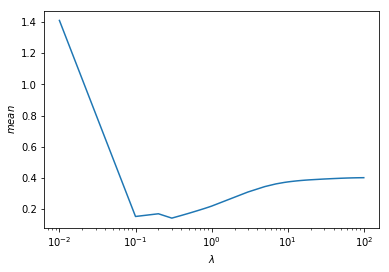

In [128]:
plt.plot(lambda_candi,mean)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("$mean$")

Text(0,0.5,'$variance$')

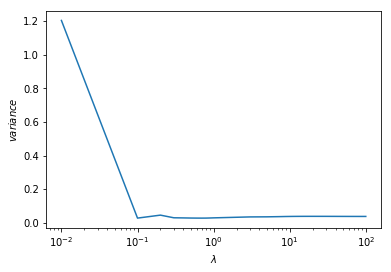

In [127]:
plt.plot(lambda_candi,std)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("$variance$")

In [129]:
w_init = np.ones((1501,1))
X_train, y_train = train_x[train_index], train_y[train_index]
X_test, y_test = train_x[test_index], train_y[test_index]
w_opt = gradientDescent(y_train,w_init,X_train,0.01,0.1)
loss = logitloss(sigmoid(w_opt,X_test), y_test).mean(axis=0)
print(loss)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


[14.5758147]


### 4.6.2 Result Analyze
From the training results above, we choose the best lambda=0.1, thetest loss is 14.5758147. 

# 5. Conclusion
In this homework, we implement batch gradient descent, and add a bias term, try different regularizers, try squared loss, use EG±, implement weighted linear least squares and stochastic gradient descent.
After the homework, we got deep understanding and practical skill of logistic regression, regularization, gradient, gradient descent and so on.